In [2]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [4]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

In [5]:
experiment = "Lung"
# cores=['DonorA', 'DonorE']
cores = ['B5', 'C6', 'D4', 'E4', 'E6', 'F4', 'F7']
datasets = [f'{core}_{i}' for core in cores for i in range(1,7)]
# datasets = ['E6_1', 'E6_2', 'E6_3']

# Load data

In [6]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [7]:
adatas = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    data_all = df_intensity_TS.iloc[:, 1:].values
    data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all_norm)
    df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    adatas.append(adata)
adata = ad.concat(adatas, join="inner")

Sucessfully read dataset B5_1
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset B5_2
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_20820/1949893129.py:26: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset B5_3
normalizing counts per cell
    finished (0:00:00)
B5_4 cannot be read
B5_5 cannot be read
B5_6 cannot be read
Sucessfully read dataset C6_1
normalizing counts per cell
    finished ({time_passed})
Sucessfully read dataset C6_2
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset C6_3
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset C6_4
normalizing counts per cell
    finished (0:00:00)
C6_5 cannot be read
C6_6 cannot be read
Sucessfully read dataset D4_1
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset D4_2
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset D4_3
normalizing counts per cell
    finished (0:00:00)
D4_4 cannot be read
D4_5 cannot be read
D4_6 cannot be read
Sucessfully read dataset E4_1
normalizing counts per cell
    finished ({time_passed})
Sucessfully read dataset E4_2
normalizing counts per cell
    finished (0:00:00)
Sucessfully read d

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


# SIMS channels plot

In [9]:
adata.obs["leiden"] = adata_IMC_cluster.obs["leiden"]
adata.uns["leiden_colors"] = adata_IMC_cluster.uns["leiden_colors"]

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_leiden']`


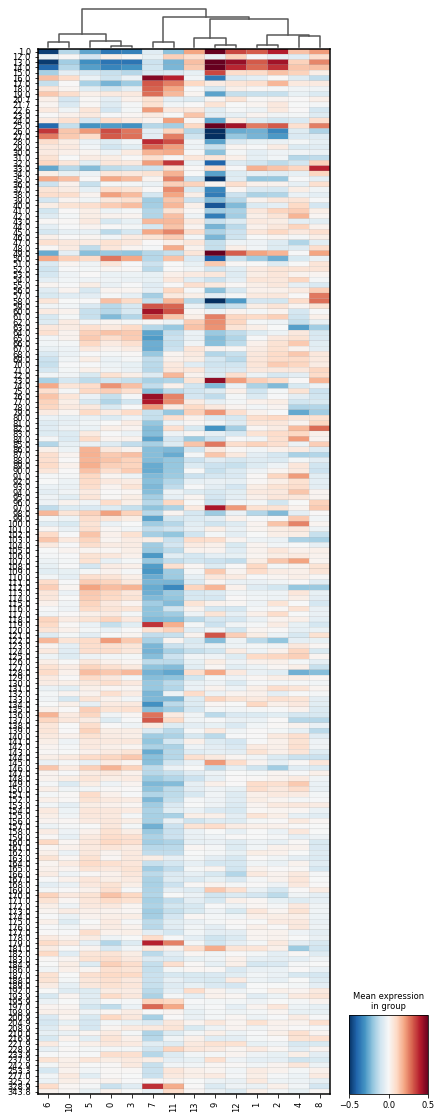

In [10]:
sc.pl.matrixplot(
    adata,
    adata.var_names.tolist(),
    "leiden",
    swap_axes=True,
    dendrogram=True,
    cmap="RdBu_r",
    figsize=(7, 20),
    vmin=-0.5, 
    vmax=0.5
)

In [11]:
df_SIMS = pd.DataFrame(adata.X, columns=adata.var_names)

# Get cluster 
cluster = adata_IMC_cluster.obs['leiden'].to_list()

# Append cluster info to single-cell matrix info for sorting and then take out cluster info
df_SIMS.loc[:,'cluster'] = np.array(cluster).astype(np.uint8)
df_SIMS_sort = df_SIMS.sort_values('cluster')
df_SIMS_sort.drop('cluster', axis=1, inplace=True)

In [12]:
# Define row type
core_labels = np.array(cluster).astype(np.uint8)
core_pal = sns.color_palette(adata_IMC_cluster.uns['leiden_colors'])
core_lut = dict(zip(map(str, np.unique(core_labels)), core_pal))
core_colors = adata_IMC_cluster.obs['leiden'].reset_index(drop=True).astype(str).map(core_lut).rename('')

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


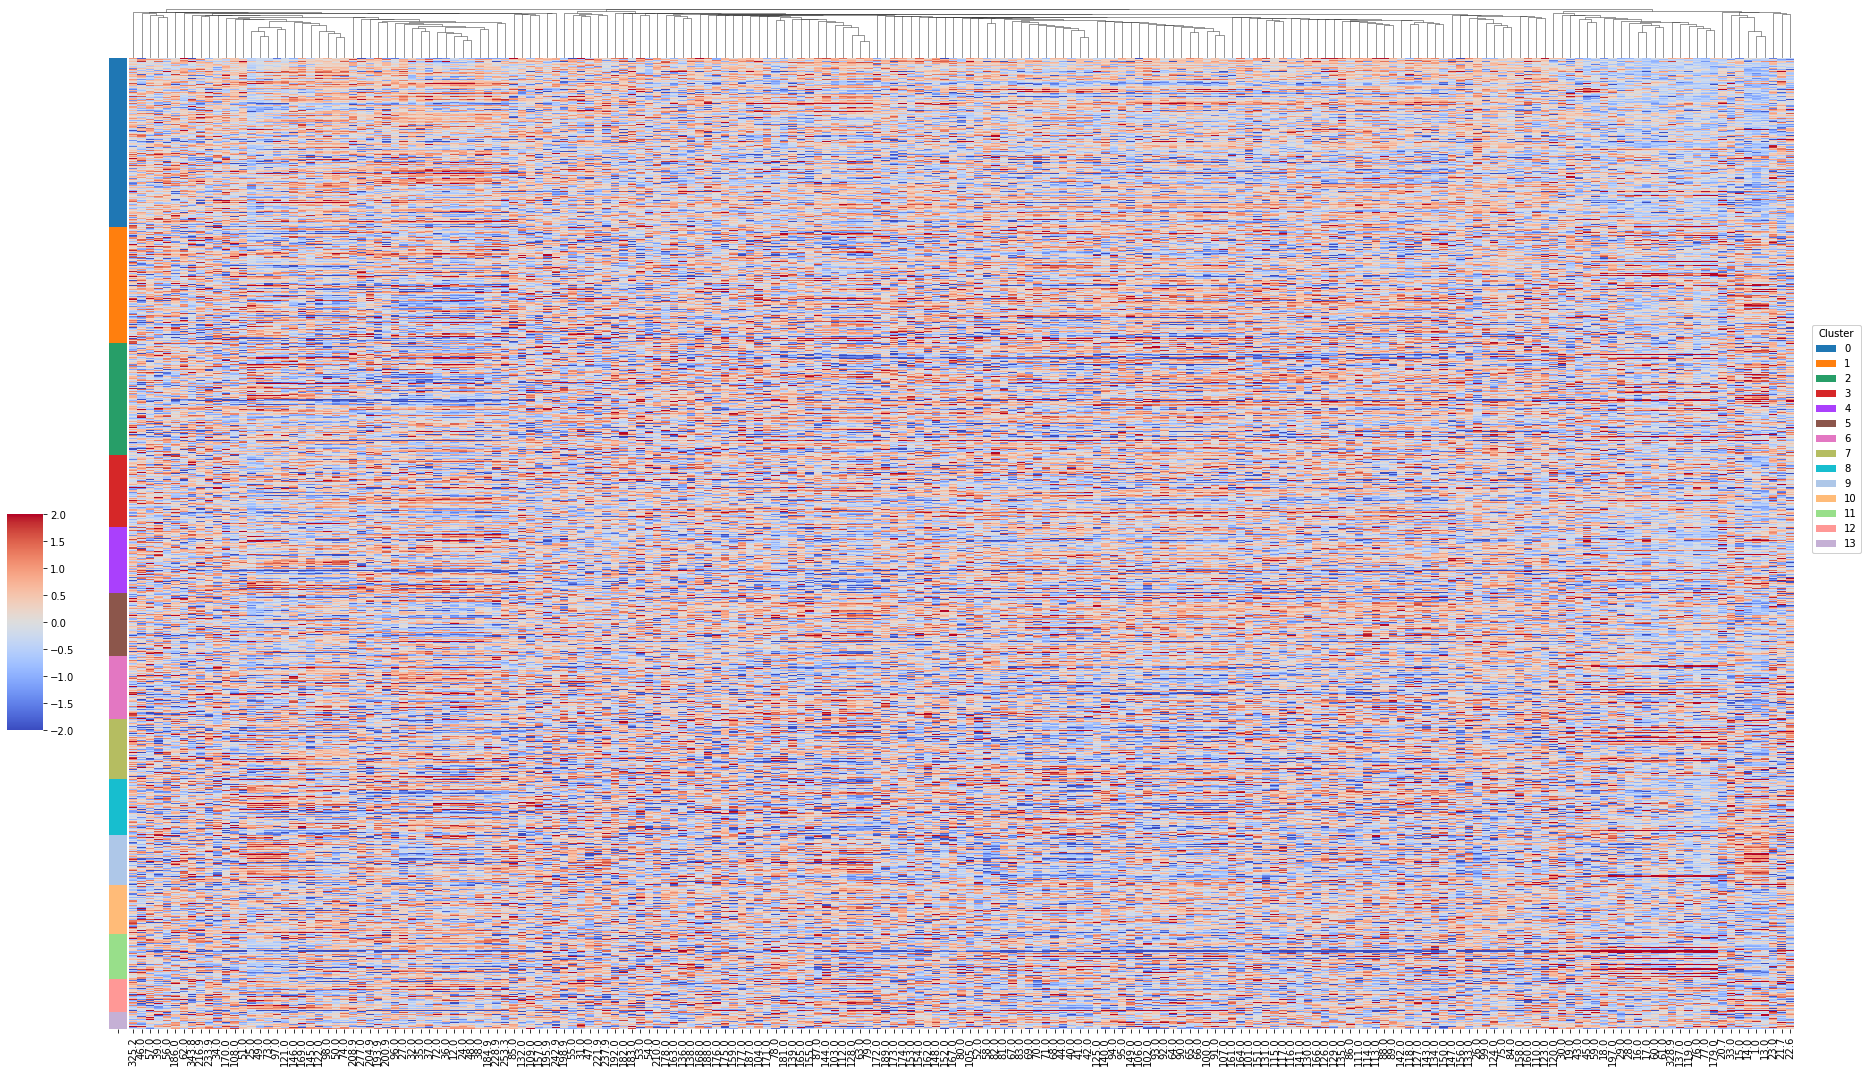

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.pyplot import gcf

g = sns.clustermap(df_SIMS_sort,
                   row_colors=core_colors,
                   cmap='coolwarm', 
                   row_cluster=False,
                   col_cluster=True,
                   colors_ratio = (0.01, 0.01),
                   cbar_pos=(.0, .32, .02, .2), 
                   dendrogram_ratio=(.05, .05), 
                   figsize=(25, 15), 
                   yticklabels=False, 
                   xticklabels=True, 
                   vmax=2,
                   vmin=-2)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
g.ax_row_dendrogram.set_visible(False)

handles3 = [Patch(facecolor=core_lut[name]) for name in core_lut]
l2 = plt.legend(handles3, core_lut, title='Cluster', bbox_to_anchor=(1, 0.7), bbox_transform=plt.gcf().transFigure, loc='upper left')

plt.gca().add_artist(l2)

plt.show()

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


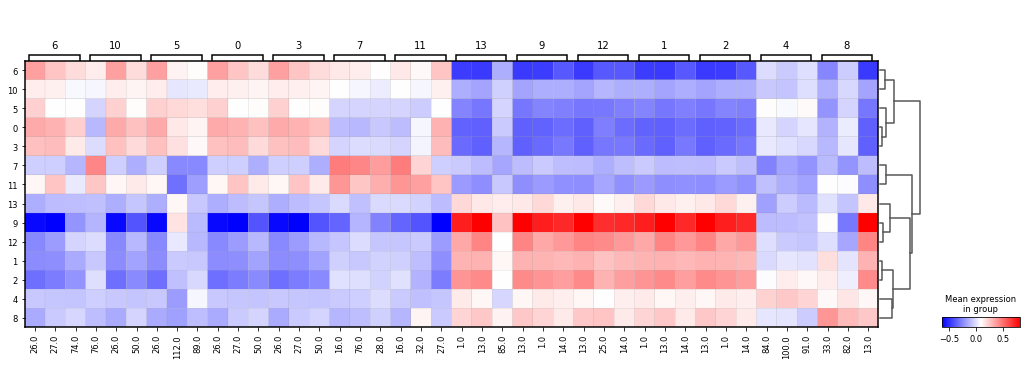

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=3, use_raw=False, cmap='bwr')

In [ ]:
dedf = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes_groups')

In [ ]:
fold_change_masses = dedf[dedf.scores > 10].names.unique().astype('float')
fold_change_masses.sort()
fold_change_masses = fold_change_masses.astype(str)

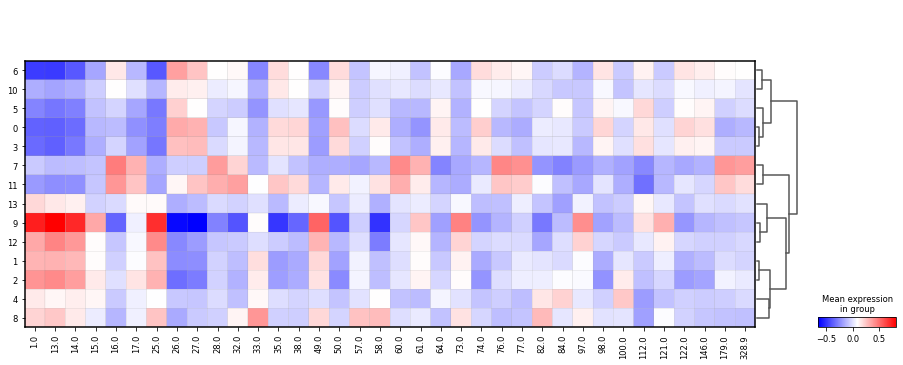

In [ ]:
sc.pl.matrixplot(adata, fold_change_masses, groupby='leiden', cmap='bwr', dendrogram=True)

## Literature Lut

In [ ]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_05052022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()
SIMS_masses = np.array(adata.var_names.to_list())

# get matched table by looking at difference with error
error = 0.5
matched_dfs = []
for mz in SIMS_masses.astype(float):
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
        
matched = pd.concat(matched_dfs)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)

SIMS_nm_subset = SIMS_masses_subset + 'm/z ' + SIMS_name_subset

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 43


In [ ]:
# Get SIMS data
adata_SIMS = adata[:, SIMS_masses_subset]
adata_SIMS.var_names = SIMS_nm_subset
df_SIMS = pd.DataFrame(adata_SIMS.X, columns=SIMS_nm_subset)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# Get cluster 
cluster = adata_IMC_cluster.obs['leiden'].to_list()

# Append cluster info to single-cell matrix info for sorting and then take out cluster info
df_SIMS.loc[:,'cluster'] = np.array(cluster).astype(np.uint8)
df_SIMS_sort = df_SIMS.sort_values('cluster')
df_SIMS_sort.drop('cluster', axis=1, inplace=True)

In [ ]:
# Define column subtype
subtype_labels = SIMS_type_subset
subtype_pal = sns.color_palette("Accent", len(np.unique(subtype_labels)))
subtype_lut = dict(zip(map(str, np.unique(subtype_labels)), subtype_pal))
subtype_colors = pd.Series(subtype_labels, index=SIMS_nm_subset).map(subtype_lut)

# Define row type
core_labels = np.array(cluster).astype(np.uint8)
core_pal = sns.color_palette(adata_IMC_cluster.uns['leiden_colors'])
core_lut = dict(zip(map(str, np.unique(core_labels)), core_pal))
core_colors = adata_IMC_cluster.obs['leiden'].reset_index(drop=True).astype(str).map(core_lut).rename('')

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


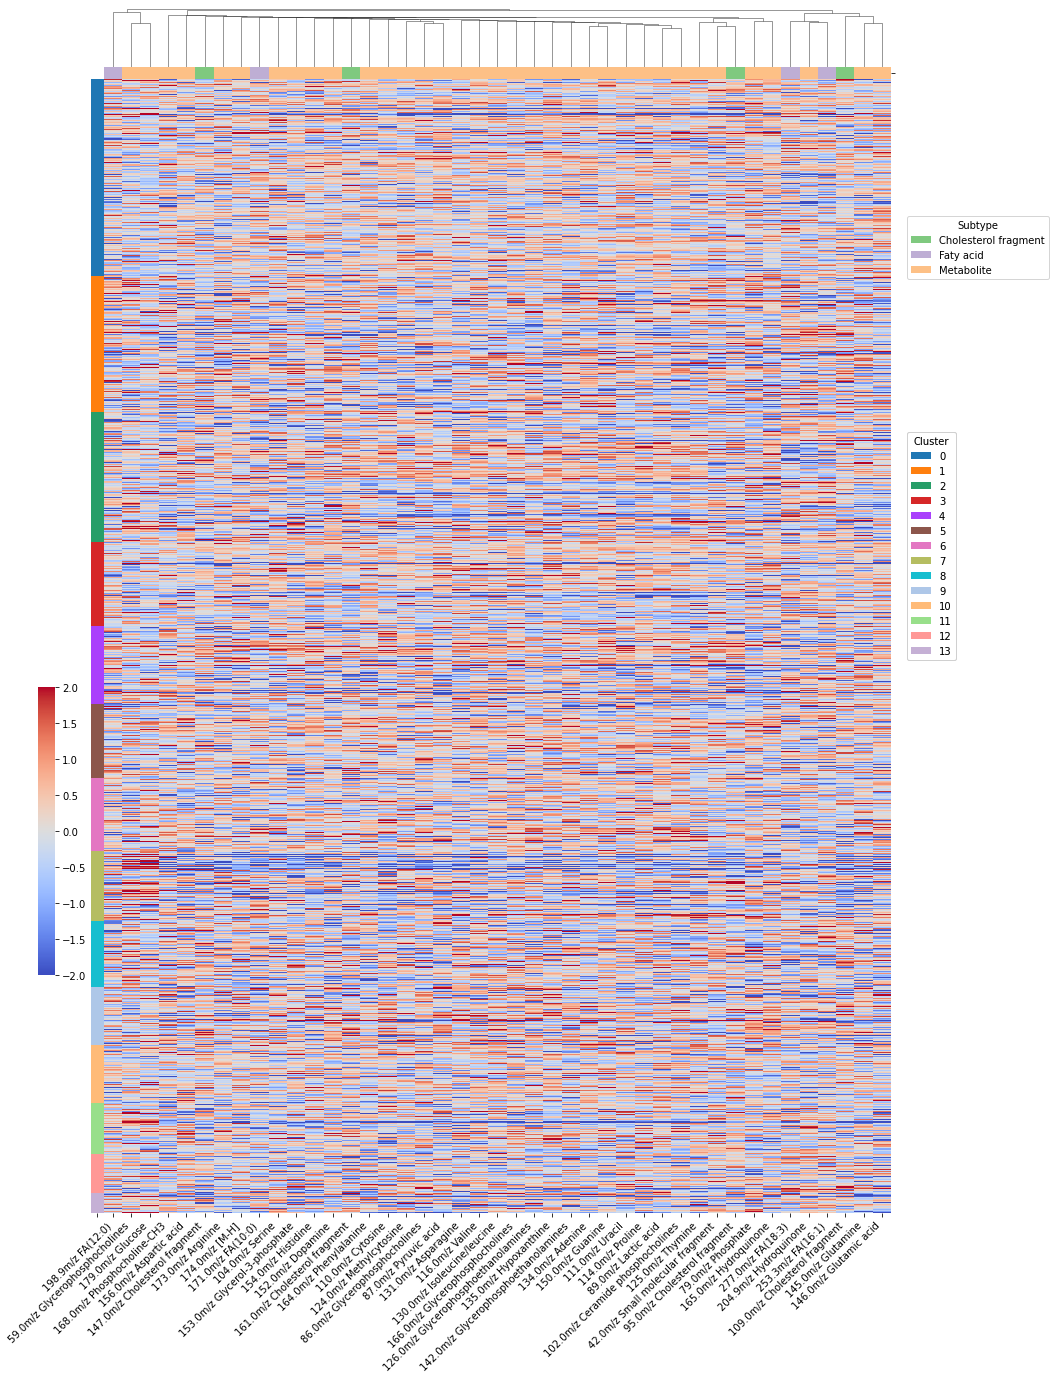

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.pyplot import gcf

g = sns.clustermap(df_SIMS_sort,
                   row_colors=core_colors,
                   col_colors=subtype_colors,
                   cmap='coolwarm', 
                   row_cluster=False,
                   col_cluster=True,
                   colors_ratio = (0.015, 0.01),
                   cbar_pos=(.0, .32, .02, .2), 
                   dendrogram_ratio=(.05, .05), 
                   figsize=(12, 20), 
                   yticklabels=False, 
                   xticklabels=True, 
                   vmax=2,
                   vmin=-2)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center')
g.ax_row_dendrogram.set_visible(False)

handles2 = [Patch(facecolor=subtype_lut[name]) for name in subtype_lut]
l2 = plt.legend(handles2, subtype_lut, title='Subtype', bbox_to_anchor=(1, 0.85), bbox_transform=plt.gcf().transFigure, loc='upper left')

handles3 = [Patch(facecolor=core_lut[name]) for name in core_lut]
l3 = plt.legend(handles3, core_lut, title='Cluster', bbox_to_anchor=(1, 0.7), bbox_transform=plt.gcf().transFigure, loc='upper left')

plt.gca().add_artist(l2)
plt.gca().add_artist(l3)

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right') 
plt.show()

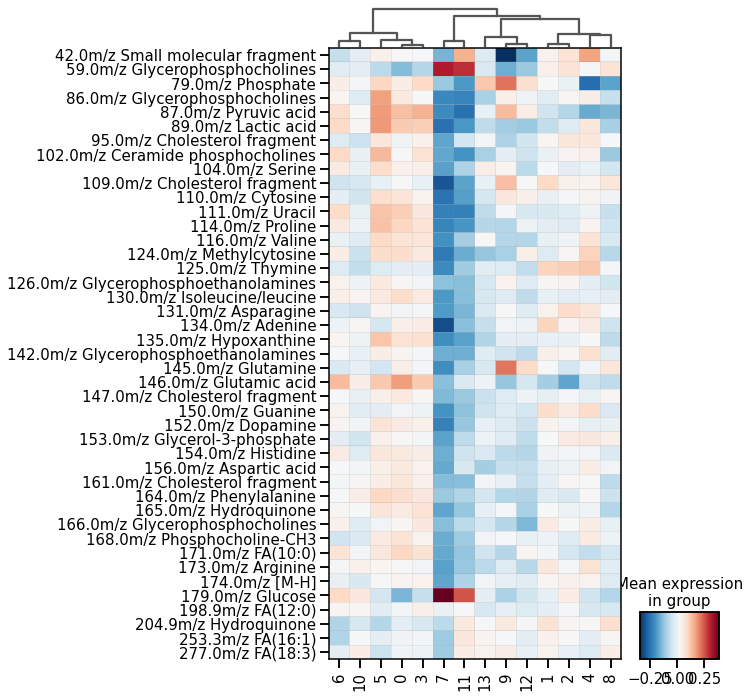

In [ ]:
with sns.plotting_context("talk", font_scale=1.):
    sc.pl.matrixplot(
        adata_SIMS,
        adata_SIMS.var_names.tolist(),
        "leiden",
        swap_axes=True,
        dendrogram=True, 
        cmap="RdBu_r",
        figsize=(7, 12),
    )

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


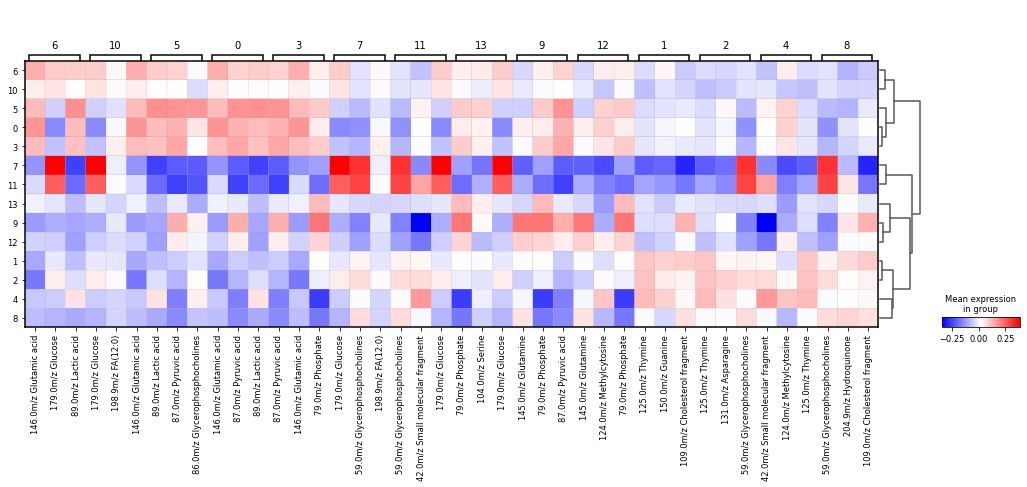

In [ ]:
sc.tl.rank_genes_groups(adata_SIMS, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups_matrixplot(adata_SIMS, n_genes=3, use_raw=False, cmap='bwr')

In [ ]:
dedf = sc.get.rank_genes_groups_df(adata_SIMS, group=None, key='rank_genes_groups')

In [ ]:
fold_change_masses = dedf[dedf.scores > 6].names.unique()


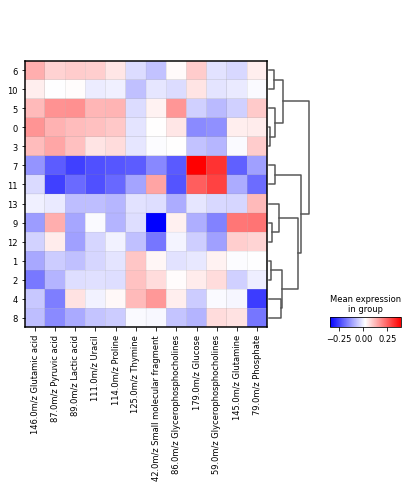

In [ ]:
sc.pl.matrixplot(adata_SIMS, fold_change_masses, groupby='leiden', cmap='bwr', dendrogram=True)


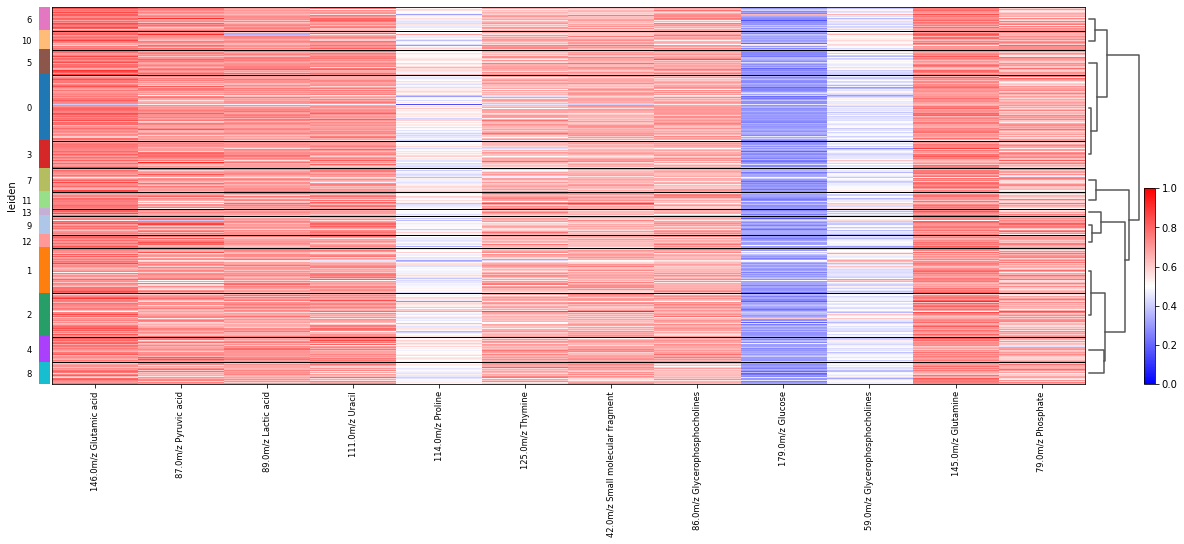

In [ ]:
sc.pl.heatmap(adata_SIMS, fold_change_masses, groupby='leiden', vmin=-5, vmax=5, cmap='bwr', dendrogram=True, swap_axes=True, figsize=(20,7))
